# Chapter 2 : 介入効果を測るための回帰分析

### Agenda

- 回帰分析を用いて、セレクションバイアスの影響を低減させることができることを確認する
- Descriptive Toolとしてのregression
- Regressionとmatchingの関係
- `statsmodels`を使いこなす

### scope外

- 漸近分散の導出

### お作法

- seed = 42は宇宙の真理（seedガチャをやっていないことを示す）

In [1]:
## create the clean environment
import gc
import matplotlib.pyplot as plt

def clear_all():
    # Clears all the variables from the workspace
    gl = globals().copy()
    for var in gl:
        if var in clean_env_var: continue
        del globals()[var]
    # Garbage collection:
    gc.collect()

def close_plots():
  my_plots = plt.get_fignums()
  for j in my_plots:
    plt.close(plt.figure(j))

clean_env_var = dir()
clean_env_var.append('clean_env_var')

In [2]:
clear_all()

### Hardware

In [3]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


### Python

In [4]:
!python -V

Python 3.7.4


### Install Packages

In [5]:
pass

### Import

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats as stats
from patsy import dmatrices
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from causalgraphicalmodels import CausalGraphicalModel
import propensity_score_matching as psmatch

## 1. Linear Regressionの紹介

OLSの推定量は以下のように導出される

$$
\beta = \arg\min_b \mathbf E[(Y_i - X_i'b)^2]
$$

Then, using FOC,

$$
E[X_i(Y_i - X_i'b)] = 0
$$

Then,

$$
\beta = E[X_iX_i']^{-1}E[X_iY_i]
$$

The sample analogue is

$$
\hat\beta = \sum_i^N (X_iX_i')^{-1}\sum_i^N (X_iY_i) = (X'X)^{-1}X'Y
$$




### OLSとEDA

`Daron Acemoglu, Simon Johnson, and James A Robinson. The colonial origins of comparative development: an empirical investigation. The American Economic Review, 91(5):1369–1401, 2001.`のデータを用いて、汚職の少なさなどの代表される政府組織の健全度と一人当たりGDPの関係を調べてみる。

### Read dta

In [7]:
df1 = pd.read_stata('https://github.com/QuantEcon/lecture-source-py/blob/master/source/_static/lecture_specific/ols/maketable1.dta?raw=true')
df1.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### GDP per capita と the protection against expropriation indexの関係

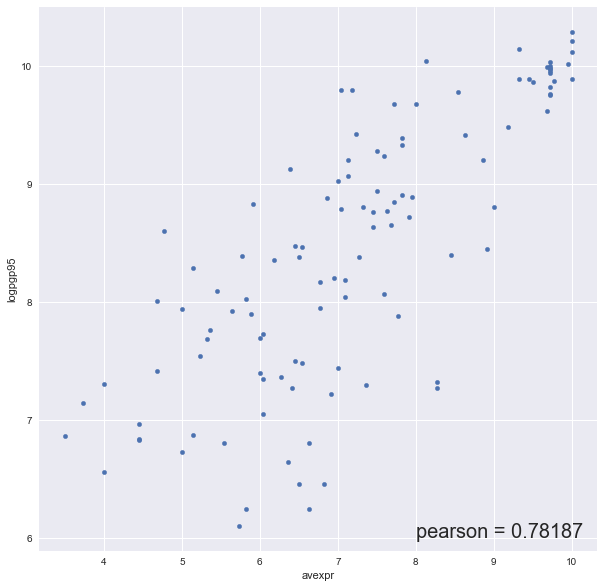

In [8]:
plt.style.use('seaborn')

df1.plot(x='avexpr', y='logpgp95', kind='scatter', figsize = (10, 10))
nas = np.logical_or(df1['avexpr'].isnull(), df1['logpgp95'].isnull())
pearson_corr = np.round(stats.pearsonr(df1.loc[~nas, 'avexpr'], df1.loc[~nas, 'logpgp95']), 5)
plt.text(8, 6, "pearson = {}".format(pearson_corr[0]), fontsize= 20)
plt.show()

Bivariate regressionでOLS estimatesを計算し、plotする

$$
{logpgp95}_i = \beta_0 + \beta_1 {avexpr}_i + u_i
$$

なお計算にあたってNAはdropする


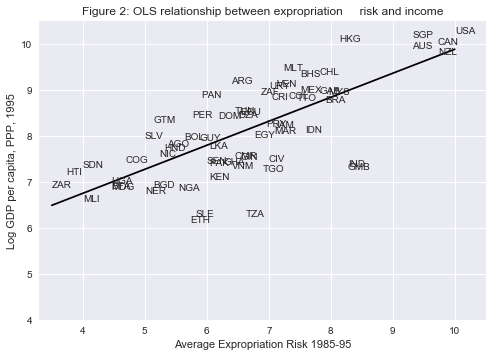

In [9]:
df1_subset = df1.dropna(subset=['logpgp95', 'avexpr'])
df1_subset = df1_subset[df1_subset['baseco'] == 1] # base-sampleに絞る

X = df1_subset['avexpr']
y = df1_subset['logpgp95']
labels = df1_subset['shortnam']
fig, ax = plt.subplots()
ax.scatter(X, y, marker='')

for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)), ## reduced-map
         color='black')

ax.set_xlim([3.3,10.5])
ax.set_ylim([4,10.5])
ax.set_xlabel('Average Expropriation Risk 1985-95')
ax.set_ylabel('Log GDP per capita, PPP, 1995')
ax.set_title('Figure 2: OLS relationship between expropriation \
    risk and income')
plt.show()

## 2. statsmodels.apiとOLS

In [10]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     72.82
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           4.72e-12
Time:                        18:22:22   Log-Likelihood:                -68.168
No. Observations:                  64   AIC:                             140.3
Df Residuals:                      62   BIC:                             144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6604      0.409     11.408      0.0

### OLSとconfidence intervalのplot

まずsimulation dataを作る

In [11]:
nsample = 50
sig = 0.5
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, np.sin(x), (x-5)**2, np.ones(nsample)))
beta = [0.5, 0.5, -0.02, 5.]

y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)

Fit and summary

In [12]:
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     348.1
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           1.29e-31
Time:                        18:22:22   Log-Likelihood:                -26.697
No. Observations:                  50   AIC:                             61.39
Df Residuals:                      46   BIC:                             69.04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5535      0.023     24.472      0.0

### Confidence intervalのplot

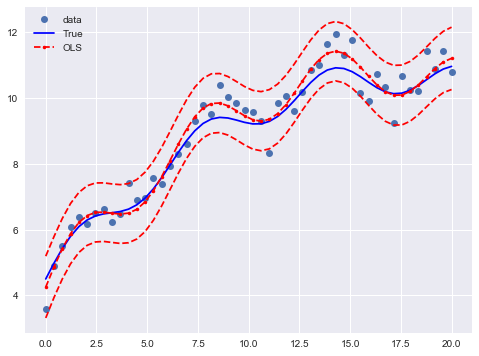

In [13]:
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'o', label="data")
ax.plot(x, y_true, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

### OLS with dummy variables

In [14]:
nsample = 50
groups = np.zeros(nsample, int)
groups[20:40] = 1
groups[40:] = 2

dummy = sm.categorical(groups, drop=True)
x = np.linspace(0, 20, nsample)
# drop reference category
X = np.column_stack((x, dummy[:,1:]))
X = sm.add_constant(X, prepend=False)

beta = [1., 3, -3, 10]
y_true = np.dot(X, beta)
e = np.random.normal(size=nsample)
y = y_true + e


res2 = sm.OLS(y, X).fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     531.6
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           1.07e-35
Time:                        18:22:23   Log-Likelihood:                -70.393
No. Observations:                  50   AIC:                             148.8
Df Residuals:                      46   BIC:                             156.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9502      0.067     14.137      0.0

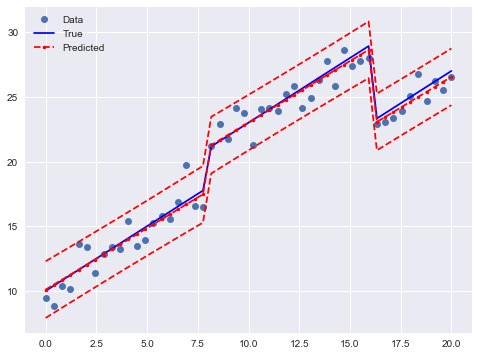

In [15]:
prstd, iv_l, iv_u = wls_prediction_std(res2)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'o', label="Data")
ax.plot(x, y_true, 'b-', label="True")
ax.plot(x, res2.fittedvalues, 'r--.', label="Predicted")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
legend = ax.legend(loc="best")

## 3. 重回帰分析とselection-on-observables

`cps.csv`dataを用いて、なぜMultivariate regressionをするのか？, matching estimatorとはどのような関係にあるのかを学ぶ。

### Question

```
job trainingはearningに対して効果があるのか？、ATTの推定
```

### Question in detailed

`RE78`（７８年の収入）に対してtreatment（76年実施）はどの程度影響を与えているのか？


### Matching Strategy

1. treatedとcontrolの比較
2. job trainingの受講スクリーニングで用いる変数,$X_i$, が観測可能という前提のもと、それらをコントロールしてmatching比較する
3. 補足：$\epsilon_i = D_i - E[D_i|X_i]$は$(Y_1, Y_0)$と独立であるという仮定

つまり、
$$
(Y_1, Y_0) \perp D_i|X_i
$$



これをDAGで表現すると

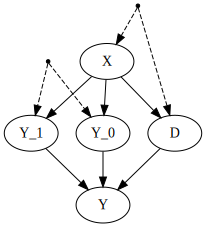

In [16]:
angrist = CausalGraphicalModel(
    nodes=["X", "D", "Y", "Y_1", "Y_0"],
    edges=[
        ("X", "D"), 
        ("D", "Y"),
        ("X", "Y_0"),
        ("X", "Y_1"),
        ("Y_1", "Y"),
        ("Y_0", "Y")
    ],
    latent_edges=[
        ("Y_1", "Y_0"),
        ("D", "X")]
)

# draw return a graphviz `dot` object, which jupyter can render
angrist.draw()

以下の場合はidentification strategyはアウト

- U: unobservables

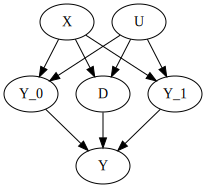

In [17]:
ill_angrist = CausalGraphicalModel(
    nodes=["X", "D", "Y", "U", "Y_1", "Y_0"],
    edges=[
        ("X", "D"), 
        ("D", "Y"),
        ("X", "Y_0"),
        ("X", "Y_1"),
        ("Y_1", "Y"),
        ("Y_0", "Y"),
        ("U", "Y_1"),
        ("U", "Y_0"),
        ("U", "D")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
ill_angrist.draw()

### Justification for Identification Strategy

- datasetは実際に受講する意思を見せた（＝採用プロセスを受けた）人に限る
- 今回はATT, $E[Y_1 - Y_0|D_i = 1]$を求めたいので$(Y_0)$とは全く無関係の要因（採用通知連絡が郵便サービスの不備によって届かなかった等）によって決定されるならば良い
    - (極端な例) 採用プロセス後の受講、受講せずの結果は本人の意思ではなく、$X_i$で条件づけられた合格確率に応じてサイコロで決められた
    
なので以下の場合は許容される

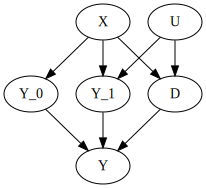

In [18]:
ok_angrist = CausalGraphicalModel(
    nodes=["X", "D", "Y", "U", "Y_1", "Y_0"],
    edges=[
        ("X", "D"), 
        ("D", "Y"),
        ("X", "Y_0"),
        ("X", "Y_1"),
        ("Y_1", "Y"),
        ("Y_0", "Y"),
        ("U", "Y_1"),
        ("U", "D")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
ok_angrist.draw()

### Estimator

Let

$$
\delta_x \equiv E[Y_i|D_i = 1, X_i] - E[Y_i|D_i = 0, X_i]
$$

and 

$$
\widehat{ATT} = E[Y_{1i} - Y_{0i}|D_i = 1] = \sum_x\delta_xPr(X_i = x|D_i = 1)
$$

- $Pr(X_i = x|D_i = 1)$: $D_i = 1$, つまりveteranのXのdensity function

### Read training data

- control: `cps.csv`
- treated: `nswre74.csv`

この二つをmergeさせて分析する

#### 変数

- treat: treatment status
- re74, re75, re78: それぞれの年度の収入
- nodeg: 学位なし



In [19]:
data_control = pd.read_csv('./data/cps.csv')
data_control = data_control.iloc[:, 1:]
data_control.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
0,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.670,25243.550,25564.670,2025.0
1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.971,5852.565,13496.080,441.0
2,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.020,25130.760,25564.670,1444.0
3,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.370,25243.550,25564.670,2304.0
4,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295,10727.610,9860.869,324.0


In [20]:
data_treated = pd.read_csv('./data/nswre74.csv')
data_treated = data_treated.iloc[:, 1:]
data_treated.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1369.0
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940,484.0
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500,900.0
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460,729.0
4,1,33,8,1,0,0,1,0.0,0.0,289.7899,1089.0


In [21]:
var_info = dict({"treat": np.int,
                "age": np.int,
                "ed": np.int,
                "black":np.int,
                "hisp":np.int,
                "married":np.int,
                "nodeg":np.int,
                "re74":np.float,
                "re75":np.float,
                "re78":np.float,
                "age2":np.int,
                })

### 変数type変換

In [22]:
data_treated = data_treated.astype(var_info)
data_control = data_control.astype(var_info)
data_control.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
0,0,45,11,0,0,1,1,21516.670,25243.550,25564.670,2025
1,0,21,14,0,0,0,0,3175.971,5852.565,13496.080,441
2,0,38,12,0,0,1,0,23039.020,25130.760,25564.670,1444
3,0,48,6,0,0,1,1,24994.370,25243.550,25564.670,2304
4,0,18,8,0,0,1,1,1669.295,10727.610,9860.869,324


### merge

In [23]:
merged_df = pd.concat([data_control, data_treated], axis = 0)
merged_df = merged_df.reset_index(drop = True)
merged_df = merged_df.sample(frac=1.0, random_state=42)  # Shuffle
merged_df.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
2616,0,41,13,0,0,1,0,25862.32000,0.000,0.000,1681
5422,0,19,12,0,0,0,0,3291.56800,12303.100,19260.690,361
3980,0,54,6,1,0,0,1,9500.48500,8706.339,4722.814,2916
11076,0,28,12,1,0,1,0,0.00000,0.000,0.000,784
7930,0,44,12,0,1,1,0,66.61507,0.000,0.000,1936


### EDA

In [24]:
merged_df.describe()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
count,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000
mean,0.011255,33.012594,11.977916,0.094117,0.072458,0.697025,0.308998,13694.237302,13318.517623,14588.222993,1211.504654
std,0.105495,11.030899,2.862478,0.292000,0.259253,0.459558,0.462094,9675.637887,9372.831224,9702.608292,782.038511
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,256.000000
25%,0.000000,24.000000,11.000000,0.000000,0.000000,0.000000,0.000000,3644.236000,3695.897000,5088.760000,576.000000
50%,0.000000,31.000000,12.000000,0.000000,0.000000,1.000000,0.000000,14655.320000,14109.530000,15962.400000,961.000000
75%,0.000000,42.000000,13.000000,0.000000,0.000000,1.000000,1.000000,23360.340000,22703.080000,25564.670000,1764.000000
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,39570.680000,25243.550000,60307.930000,3025.000000


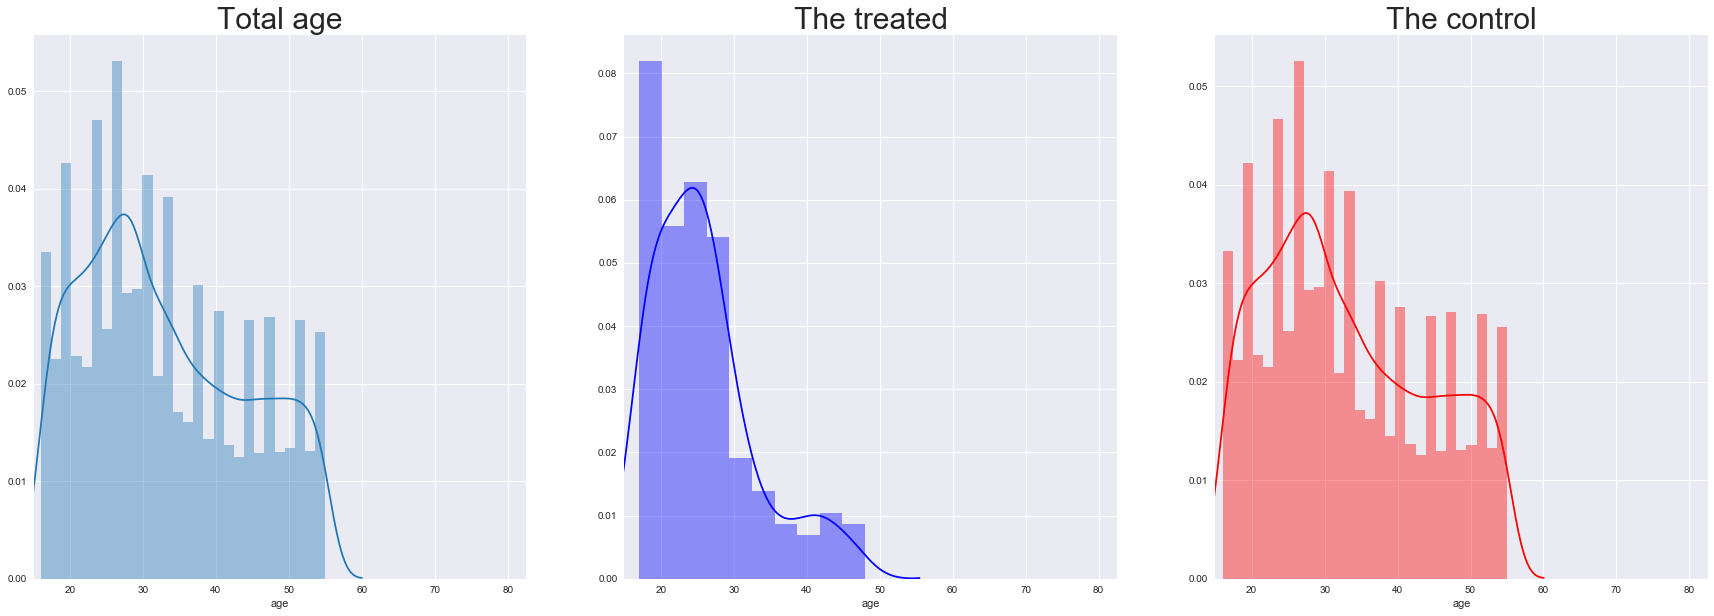

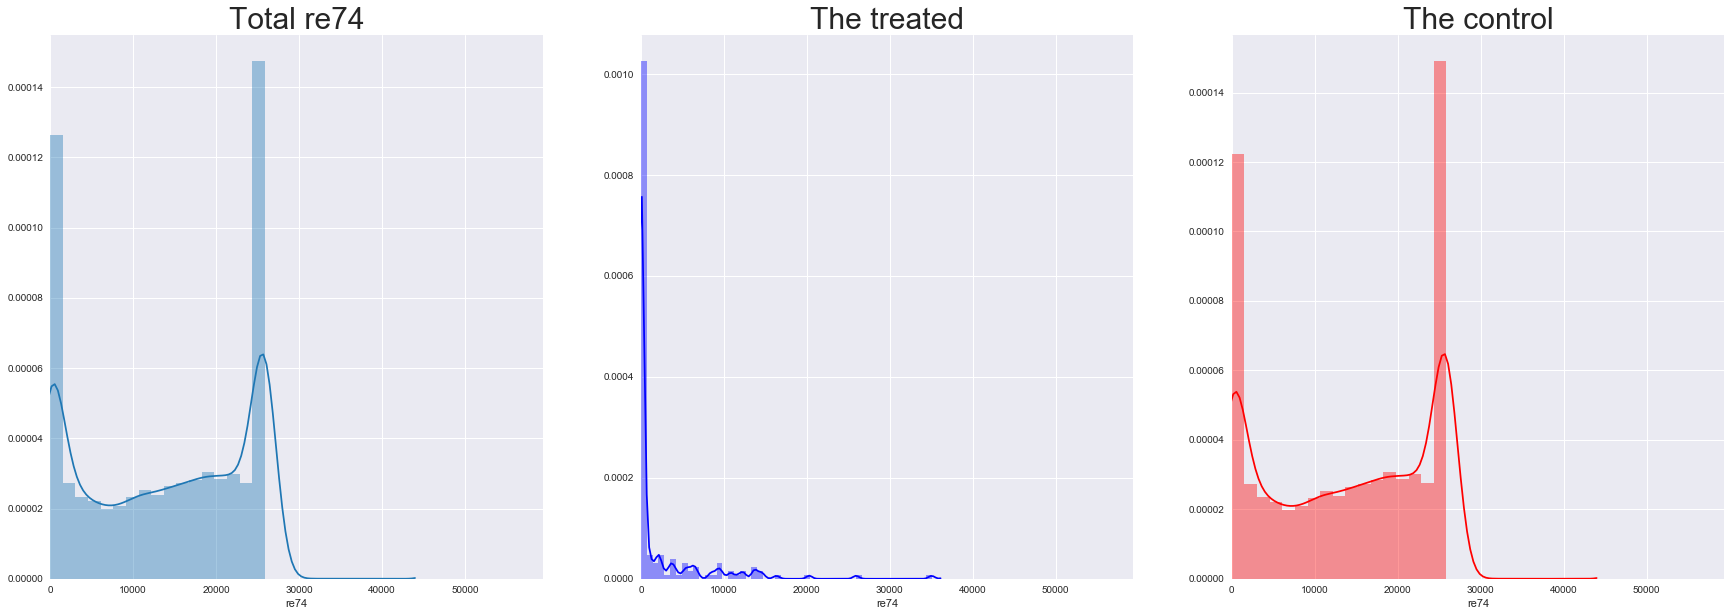

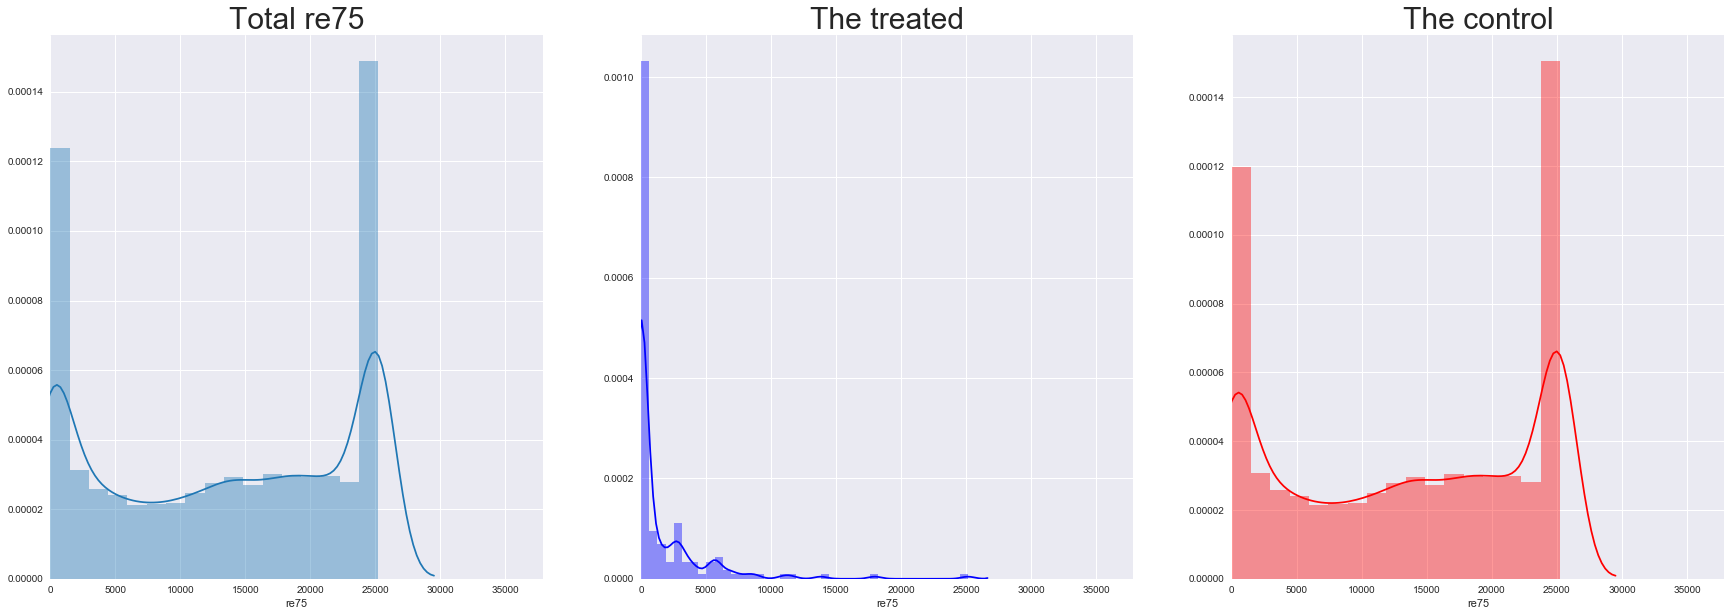

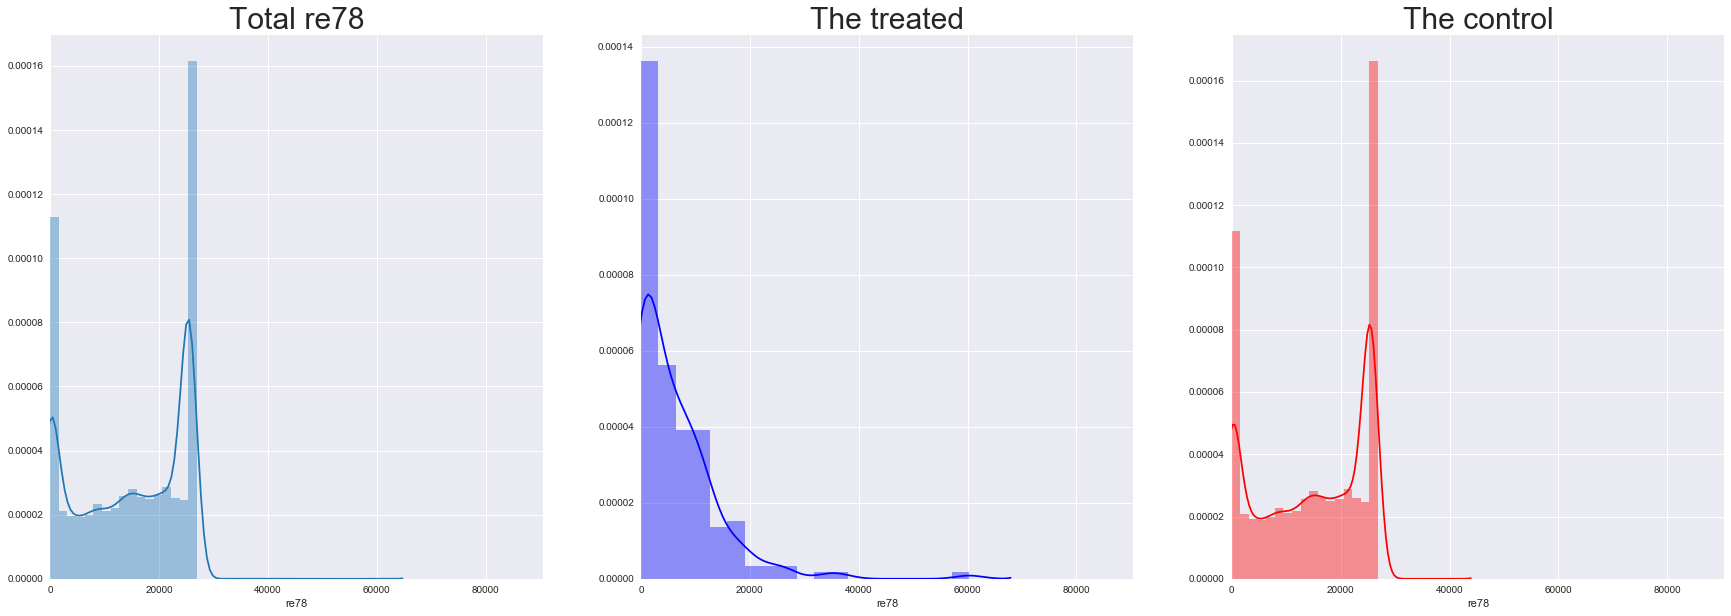

In [25]:
columns = ['age', 're74', 're75', 're78']
for i, column in enumerate(columns):
    fig, axs = plt.subplots(1, 3, figsize=(30,10))
    sns.distplot(merged_df[column], color="#1f77b4", ax = axs[0]).set_title('Total ' + column,fontsize=30)
    sns.distplot(merged_df[merged_df['treat'] >= .5][column], color="blue", ax = axs[1]).set_title('The treated',fontsize=30)
    sns.distplot(merged_df[merged_df['treat'] < .5][column], color="red", ax = axs[2]).set_title('The control',fontsize=30)
    for j in range(0, 3):
        axs[j].set_xlim(min(merged_df[column])-1, max(merged_df[column]*1.5 ))
    plt.show()

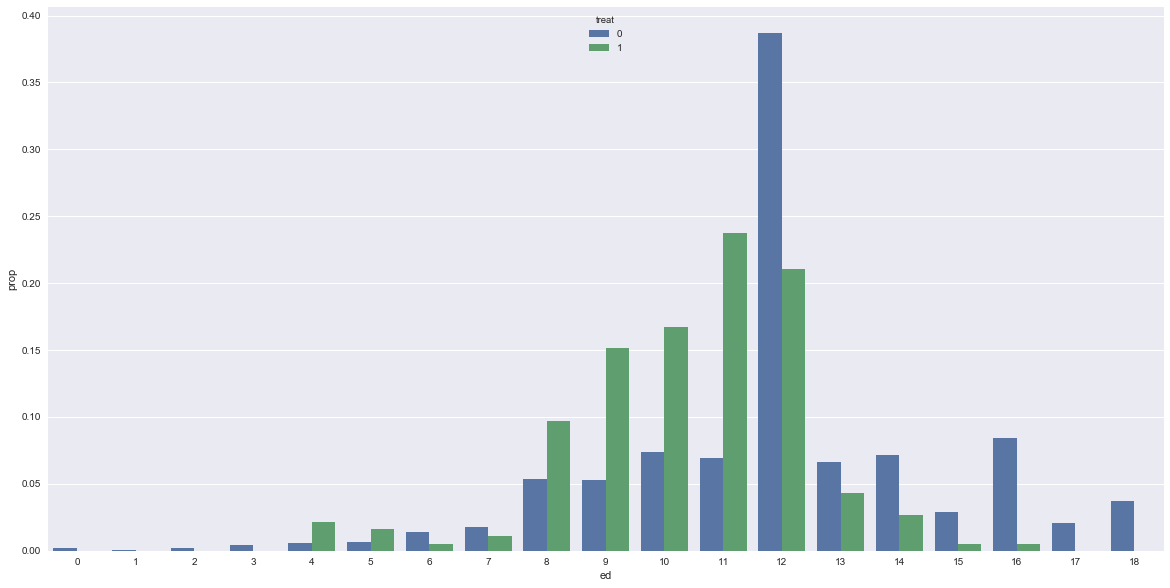

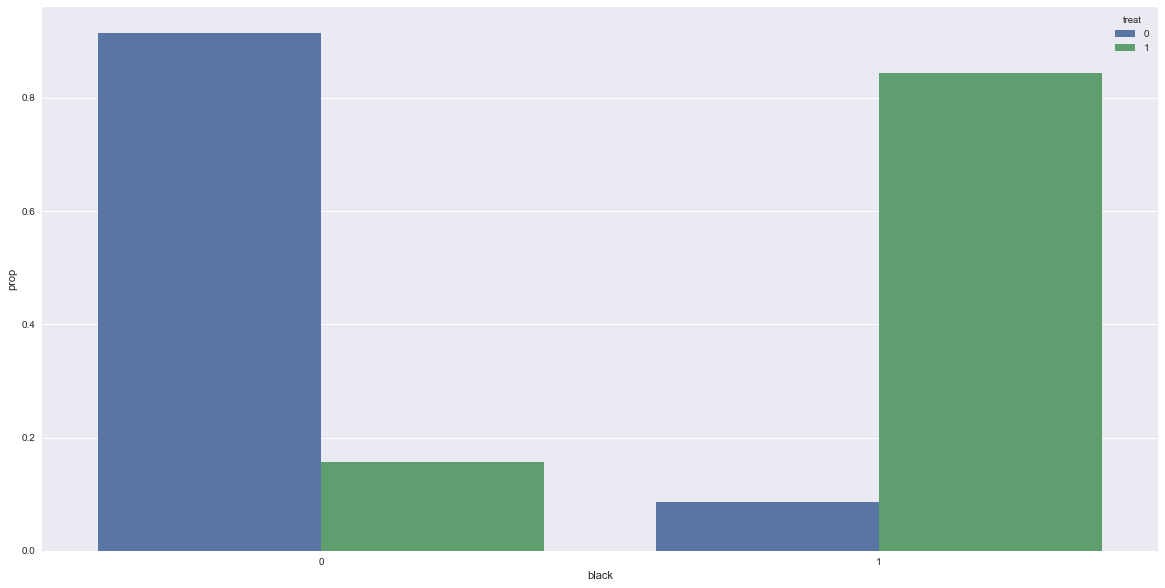

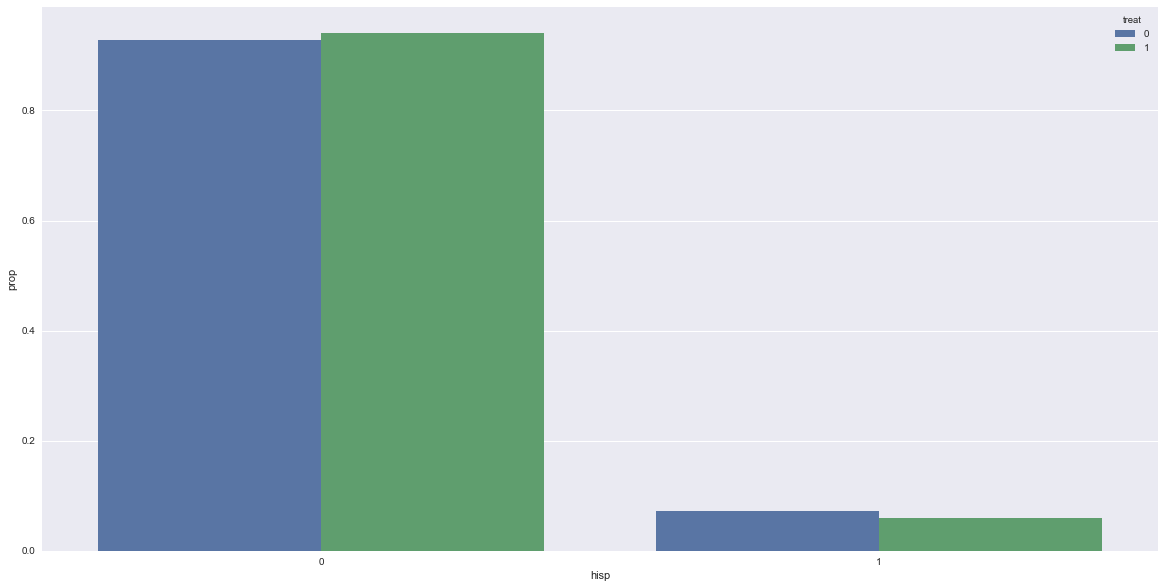

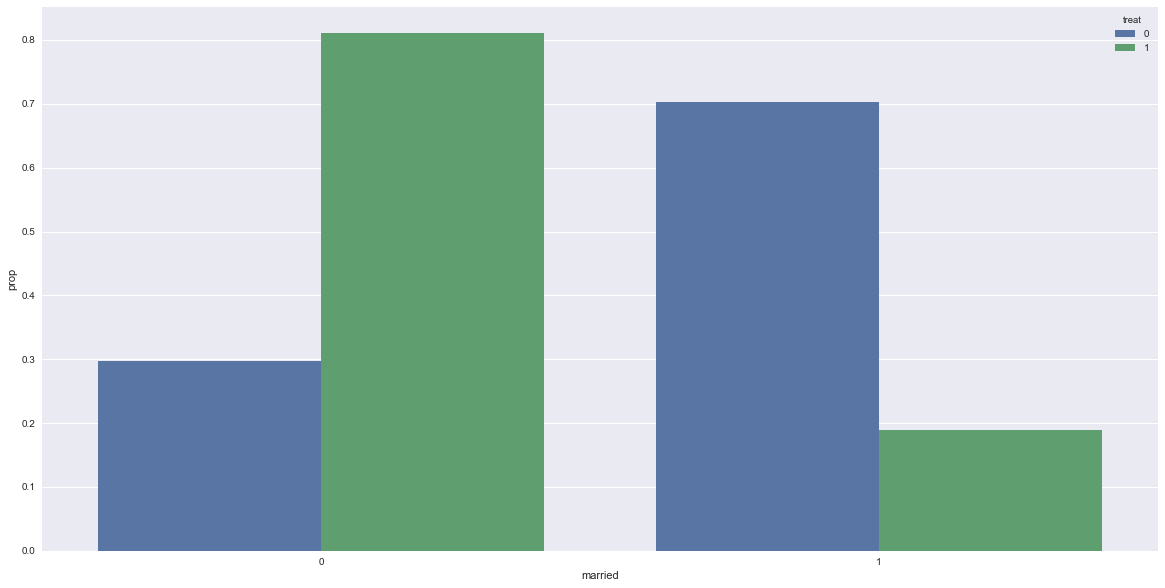

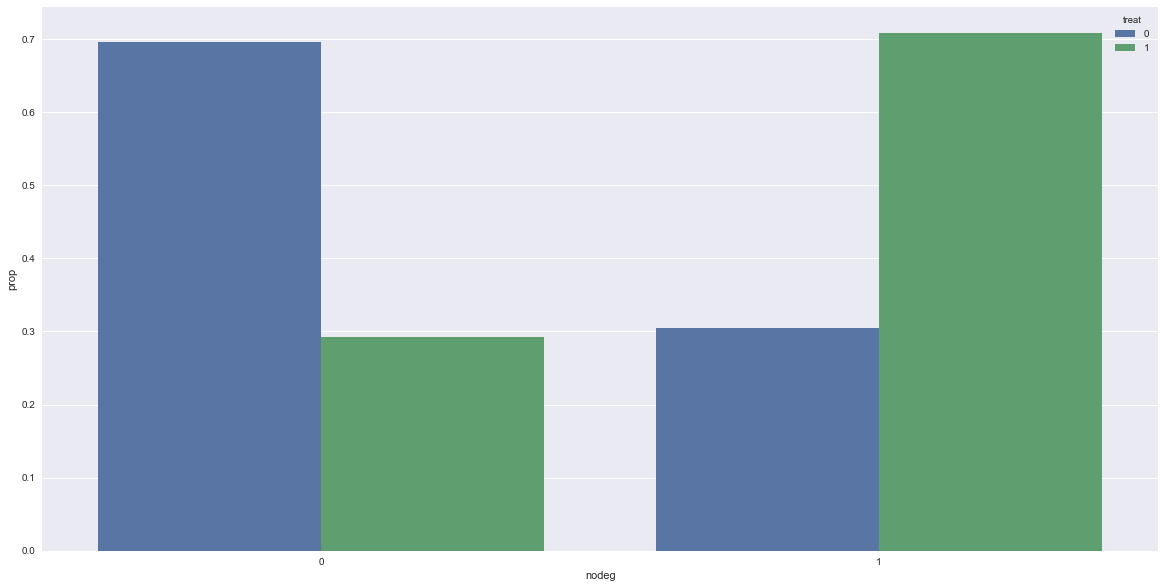

In [26]:
columns = ['ed', 'black', 'hisp', 'married', 'nodeg']
hue = 'treat'
y = 'prop'

for i, column in enumerate(columns):
    fig, axs = plt.subplots(1, 1, figsize=(20,10))
    prop_df = (merged_df.groupby("treat")[column]
               .value_counts(normalize=True)
               .rename(y)
               .reset_index())
    
    sns.barplot(x=column, y=y, hue = hue, data=prop_df, ax=axs)

### Normalized Difference

ATE, ATT, ATCの推定にはcommon support, overlapが必要条件だがその確認のための統計量としてNormazlied Differenceがある。

$$
\text{Normalized Difference}_j = \frac{|\bar x_{treated, j} - \bar x_{control, j}|}{(s_{treated, j}^2 + s_{control, j}^2)^{1/2}}
$$

- j: covariateのindex
- Imbens and Rubinはnormalized differenceが0.25を超えた場合、overlapに問題があるとしている


In [27]:
colnames = list(merged_df.columns)
for i in ['treat', 're78']:
    colnames.remove(i)
normed_diff = merged_df.groupby(['treat']).agg([np.mean, 'var'])
normed_diff

age                     ed               black            \
            mean         var       mean       var      mean       var   
treat                                                                   
0      33.094511  121.890027  11.996493  8.210621  0.085589  0.078269   
1      25.816216   51.194301  10.345946  4.042714  0.843243  0.132902   

           hisp             married               nodeg            \
           mean       var      mean       var      mean       var   
treat                                                               
0      0.072606  0.067339  0.702806  0.208883  0.304455  0.211775   
1      0.059459  0.056228  0.189189  0.154230  0.708108  0.207814   

               re74                        re75                        re78  \
               mean           var          mean           var          mean   
treat                                                                         
0      13826.267376  9.286444e+07  13452.685450  8.713324e+07  14682.010201   
1       2095.573689  2.387906e+07   1532.055314  1.036358e+07   6349.143530   

                            age2                 
                var         mean            var  
treat                                            
0      9.372992e+07  1217.129215  613629.780115  
1      6.189602e+07   717.394595  185978.033666

In [28]:
def compute_normed_diff(df, feature, round_digits = 5):
    snd = []
    for i in feature:
        tmp_df = df[i].values
        neg_mean = tmp_df[0, 0]
        neg_std = tmp_df[0, 1]
        pos_mean = tmp_df[1, 0]
        pos_std = tmp_df[1, 1]
        smd = (pos_mean - neg_mean) / np.sqrt((pos_std+ neg_std) / 2)
        smd = round(abs(smd), round_digits)
        snd.append(smd)

    return pd.DataFrame({'features': feature, 'snd': snd})
    

In [29]:
snd = compute_normed_diff(normed_diff, feature = colnames)
snd

,features,snd
0,age,0.78238
1,ed,0.66683
2,black,2.33168
3,hisp,0.05289
4,married,1.20541
5,nodeg,0.88127
6,re74,1.53540
7,re75,1.70734
8,age2,0.79034


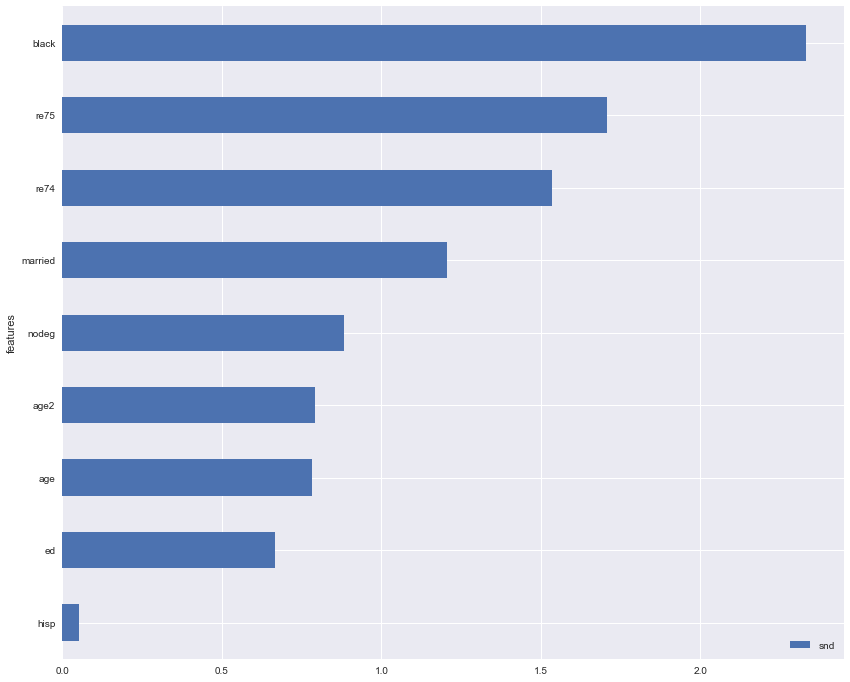

In [30]:
snd = snd.sort_values('snd')
snd.plot.barh(x='features', y='snd', figsize=(14,12));

### Naive estimator

In [31]:
#merged_df = pd.get_dummies(merged_df, columns=["ed"], drop_first=True)
merged_df = merged_df.join((merged_df[["re74", "re75"]] == 0).astype(int), rsuffix=("_0"))


In [32]:
treatment_params = dict()

In [33]:
naive = merged_df.groupby('treat')['re78'].mean()
naive[2] = naive[1] - naive[0]
res = pd.DataFrame(naive.reset_index(drop = True)).T
res.columns = ['control mean', 'treated mean', 'mean diff']
res

,control mean,treated mean,mean diff
re78,14682.010201,6349.14353,-8332.86667


In [34]:
treatment_params['naive'] = res['mean diff'].values[0]

### OLS estimator

In [35]:
X = merged_df.drop('re78', axis = 1)
Y = merged_df.loc[:,'re78']
X = sm.add_constant(X)
ols_res = sm.OLS(Y, X).fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     1279.
Date:                Wed, 22 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:22:33   Log-Likelihood:            -1.6879e+05
No. Observations:               16437   AIC:                         3.376e+05
Df Residuals:                   16424   BIC:                         3.377e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7213.9852    728.641      9.901      0.0

In [36]:
treatment_params['OLS'] = ols_res.params['treat']

### Propensity Score matching

In [37]:
merged_df.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2,re74_0,re75_0
2616,0,41,13,0,0,1,0,25862.32000,0.000,0.000,1681,0,1
5422,0,19,12,0,0,0,0,3291.56800,12303.100,19260.690,361,0,0
3980,0,54,6,1,0,0,1,9500.48500,8706.339,4722.814,2916,0,0
11076,0,28,12,1,0,1,0,0.00000,0.000,0.000,784,1,1
7930,0,44,12,0,1,1,0,66.61507,0.000,0.000,1936,0,1


In [38]:
logit_formula = 'treat~ 1+age+black+hisp+married+nodeg+re74+re75+age2+ed+re74_0+re75_0'

In [39]:
logit_res = smf.logit(formula=logit_formula, data=merged_df).fit()
propensity_score = logit_res.predict()
merged_df['p_logit'] = propensity_score

Optimization terminated successfully.
         Current function value: 0.032973
         Iterations 12


common supportのvisualization

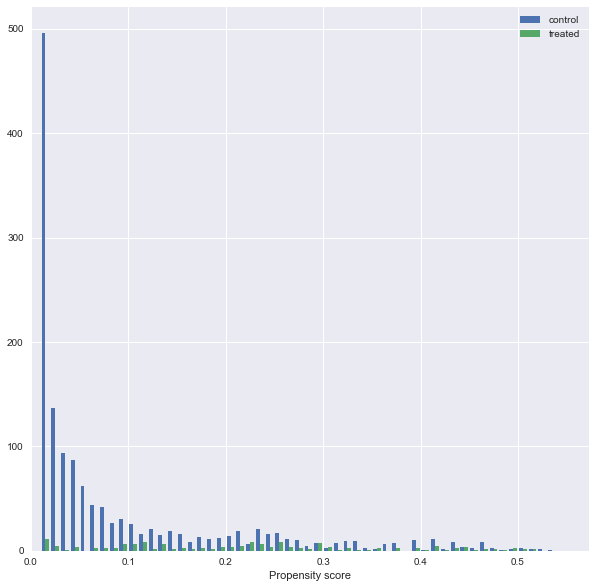

In [40]:
prob_untreated = merged_df.loc[merged_df['treat'] == 0, 'p_logit']
prob_treated =  merged_df.loc[merged_df['treat'] == 1, 'p_logit']
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
bins = np.linspace(0.01, 1.00, 100)
ax.hist([prob_untreated, prob_treated], bins=bins, label=['control', 'treated'])
ax.set_xlim([0, max(merged_df['p_logit'])])
ax.set_xlabel('Propensity score')
ax.legend();

propensity scoreを用いたATE, ATT, ATCの推定

In [41]:
treatment_params['PS_ATT'] = psmatch.get_att_weight(merged_df, p = propensity_score, outcome = 're78', treat = 'treat' )
treatment_params['PS_ATE'] = psmatch.get_ate_weight(merged_df, p = propensity_score, outcome = 're78', treat = 'treat' )
treatment_params['PS_ATC'] = psmatch.get_atc_weight(merged_df, p = propensity_score, outcome = 're78', treat = 'treat' )

### Nearest Neighbour Matching

In [42]:
treated_df = merged_df.loc[merged_df['treat'] == 1].reset_index(drop = True)
non_treated_df = merged_df.loc[merged_df['treat'] == 0].reset_index(drop = True)

In [43]:
treated = treated_df['p_logit'].values
non_treated = non_treated_df['p_logit'].values

nbrs = NearestNeighbors(n_neighbors=1,
                        algorithm='ball_tree').fit(non_treated.reshape(-1, 1))
distances, indices = nbrs.kneighbors(treated.reshape(-1, 1))
indices = indices.reshape(indices.shape[0])
matched = non_treated_df.loc[indices]

どの程度マッチしているか可視化してみる

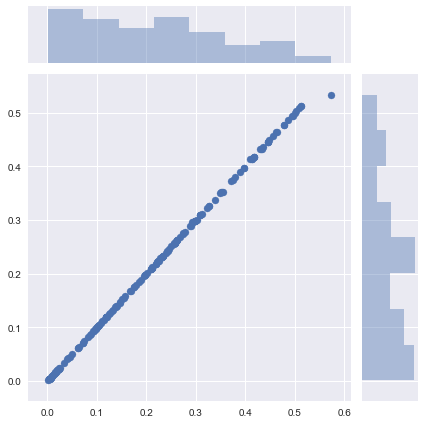

In [44]:
sns.jointplot(treated, matched['p_logit'].values);

In [45]:
treatment_params['Nearest_ATT'] = np.mean(treated_df['re78']) - np.mean(matched['re78'])
treatment_params['Nearest_ATT']

1224.839727675675

ATCも計算してみる

In [46]:
nbrs = NearestNeighbors(n_neighbors=1,
                        algorithm='ball_tree').fit(treated.reshape(-1, 1))
distances, indices = nbrs.kneighbors(non_treated.reshape(-1, 1))
indices = indices.reshape(indices.shape[0])
matched_atc = treated_df.loc[indices]

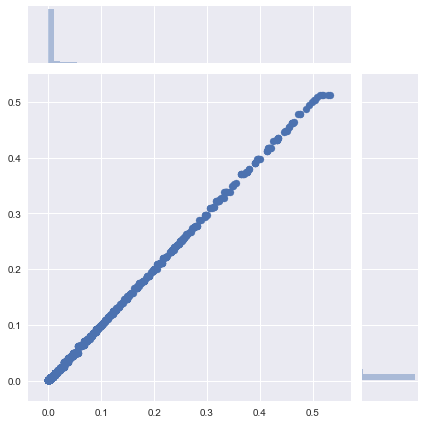

In [47]:
sns.jointplot(non_treated, matched_atc['p_logit'].values);

In [48]:
treatment_params['Nearest_ATC'] = np.mean(matched_atc.re78) - np.mean(non_treated_df['re78'])
treatment_params['Nearest_ATC'] 

-3653.6808865858366

CIAのAssumptionが成立していないと思われる

### 統計量の比較

In [49]:
pd.DataFrame(treatment_params.values(),
             index = treatment_params.keys(),
             columns = ['effect_size'])

,effect_size
naive,-8332.866670
OLS,1204.027732
PS_ATT,1402.255464
PS_ATE,-6779.472819
PS_ATC,-6872.607186
Nearest_ATT,1224.839728
Nearest_ATC,-3653.680887


Propensity Score ATTの推定とOLSの推定は比較的近い値を計算している。

### Regression Meets Matching

The Horvitz-Thompson matching estimandsを振り返る:

$$
E[Y_{1i} - Y_{0i}] = E\left[\frac{D_i - P(X)i)Y_i}{P(X_i)(1 - P(X_i))}\right]
$$

and

$$
E[Y_{1i} - Y_{0i}|D_i = 1] = E\left[\frac{D_i - P(X)i)Y_i}{\rho(1 - P(X_i))}\right]
$$

where $\rho$はsampleのtreated割合。

Hirano, Imbens, and Ridder(2003)はregressionとThe Horvitz-Thompson matching estimandsが同じweighted average estimand classに属することを示した：

$$
E\left\{g(X_i)\left[\frac{D_iY_i}{P(X_i)} - \frac{(1 - D_i)Y_i}{(1 - P(X_i))} \right]\right\}
$$

- $g(X_i) = 1$: ATE
- $g(X_i) = p(X_i)/P(D_i = 1)$: ATT
- $g(X_i) = p(X_i)(1 - p(X_i))/E[p(X_i)(1 - p(X_i))]$: OLS

よって、OLSは$p(X_i)(1 - p(X_i))$が大きいところ＝treatment assignmentが50:50に近いところに大きいweightを置いている事がわかる。上のpropensity scoreの分布と照らし合わせると、ATTと近い間が出る。

## 4. メールマーケティングデータの分析（回帰編）

biased datasetを用いて重回帰分析によってどの程度biasが除去できるか検討する。EDAについてはch01参照。

In [50]:
df = pd.read_csv('http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  int64  
 10  conversion       64000 non-null  int64  
 11  spend            64000 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 5.9+ MB


,recency,history,mens,womens,newbie,visit,conversion,spend
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781,0.009031,1.050908
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890,0.094604,15.036448
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000,499.000000


バイアスのあるデータを作成

In [51]:
## 前処理
df.loc[:, 'treatment'] = df['segment'].map(lambda x: 1 if x == 'Mens E-Mail' else 0)
male_df = df.loc[df['segment'] != 'Womens E-Mail']
male_df.info()
male_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42613 entries, 1 to 63999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          42613 non-null  int64  
 1   history_segment  42613 non-null  object 
 2   history          42613 non-null  float64
 3   mens             42613 non-null  int64  
 4   womens           42613 non-null  int64  
 5   zip_code         42613 non-null  object 
 6   newbie           42613 non-null  int64  
 7   channel          42613 non-null  object 
 8   segment          42613 non-null  object 
 9   visit            42613 non-null  int64  
 10  conversion       42613 non-null  int64  
 11  spend            42613 non-null  float64
 12  treatment        42613 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 4.6+ MB


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0


In [52]:
def bias(s):
  loyal = s['history'] > 300 or s['recency'] < 3 or s['channel'] == 'Multichannel'
  if (s['treatment'] == 1 and not loyal) or (s['treatment'] == 0 and loyal):
    return 0.5
  else:
    return 1.0

biased_data = male_df.sample(frac=0.5, weights=male_df.apply(bias, axis=1), random_state=42)
biased_data.info()
biased_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21306 entries, 24106 to 56013
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          21306 non-null  int64  
 1   history_segment  21306 non-null  object 
 2   history          21306 non-null  float64
 3   mens             21306 non-null  int64  
 4   womens           21306 non-null  int64  
 5   zip_code         21306 non-null  object 
 6   newbie           21306 non-null  int64  
 7   channel          21306 non-null  object 
 8   segment          21306 non-null  object 
 9   visit            21306 non-null  int64  
 10  conversion       21306 non-null  int64  
 11  spend            21306 non-null  float64
 12  treatment        21306 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 2.3+ MB


,recency,history,mens,womens,newbie,visit,conversion,spend,treatment
count,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000,21306.000000
mean,5.783958,241.820497,0.550690,0.549188,0.502347,0.145593,0.009152,1.098233,0.483291
std,3.518513,258.443012,0.497436,0.497586,0.500006,0.352706,0.095231,15.986469,0.499732
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,156.125000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,324.927500,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,12.000000,3215.970000,1.000000,1.000000,1.000000,1.000000,1.000000,499.000000,1.000000


In [53]:
## OLSをstatsmodels apiで実行
y, X = dmatrices('spend ~ treatment + history', data = biased_data, return_type='dataframe')
model = sm.OLS(y, X)
res = model.fit()

In [54]:
summary = res.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.35
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           3.21e-05
Time:                        18:23:10   Log-Likelihood:                -89276.
No. Observations:               21306   AIC:                         1.786e+05
Df Residuals:                   21303   BIC:                         1.786e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4921      0.176      2.792      0.0

### REMARKS
- Rの実行結果と異なる理由は、biased_data作成がランダムサンプルのため

In [55]:
## 推定されたパラメーターを取り出す
coef = summary.tables[1]
print(type(coef))
print(coef)

<class 'statsmodels.iolib.table.SimpleTable'>
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4921      0.176      2.792      0.005       0.147       0.838
treatment      0.8483      0.221      3.836      0.000       0.415       1.282
history        0.0008      0.000      1.897      0.058    -2.7e-05       0.002


なおパラメータのみを取り出したいときは

In [56]:
print(res.params)

Intercept    0.492055
treatment    0.848338
history      0.000811
dtype: float64


residualも一応計算

In [57]:
beta = res.params.values
beta.shape = 3, 1
beta.shape
residual = y.values - X.values @ beta 

In [58]:
residual.shape

(21306, 1)

不均一分散かどうかplotで確認

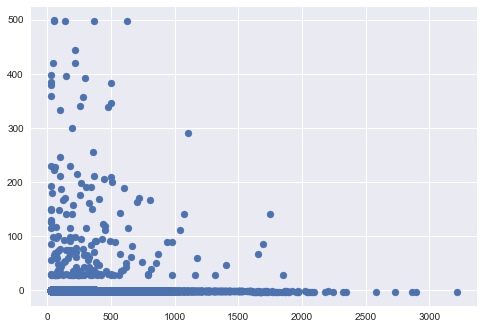

In [59]:
plt.scatter(X['history'], residual);

### 不均一分散の検定

- ブルーシュ＝ペーガン検定
- ホワイト検定

#### ホワイト検定とブルーシュ＝ペーガン検定

どちらもresidualsの自乗を説明変数に回帰させ、F testを実施する。

- 1次の項のみ：ブルーシュ＝ペーガン検定
- 2次の項も含む：ホワイト検定


In [60]:
white_test = het_white(residual,  X)
bp_test = het_breuschpagan(residual,  X)

In [61]:
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
df1 = pd.DataFrame(dict(zip(labels, bp_test)).values(), 
                   index = dict(zip(labels, bp_test)).keys(),
                   columns = ['bq test'])

df2 = pd.DataFrame(dict(zip(labels, white_test)).values(), 
                   index = dict(zip(labels, bp_test)).keys(),
                   columns = ['white test'])

pd.concat([df1, df2], axis = 1)

,bq test,white test
LM Statistic,9.664875,10.198808
LM-Test p-value,0.007967,0.037209
F-Statistic,4.833950,2.550324
F-Test p-value,0.007964,0.037201


不均一分散が存在すると解釈できる。なのでOLSを用いるときはWhiteのheteroskedasticity-robust standard errorを用いてregressionを実施すべきと解釈できる。

### heteroskedasticity robust standard errors

`fit()`methodを呼ぶときに`cov_type`をしてするだけで良い

In [62]:
res_white = model.fit(cov_type = 'HC0', use_t = True)
summary = res_white.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.477
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           7.69e-05
Time:                        18:23:10   Log-Likelihood:                -89276.
No. Observations:               21306   AIC:                         1.786e+05
Df Residuals:                   21303   BIC:                         1.786e+05
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4921      0.147      3.347      0.0

## 5. 回帰分析におけるバイアス

In [63]:
## RCTデータでの単回帰
y, X = dmatrices('spend ~ treatment', data = male_df, return_type = 'dataframe')
results_unbiased_1 = sm.OLS(y, X).fit()
rct_reg_coef = results_unbiased_1.summary().tables[1]
rct_reg_coef

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6528,0.103,6.356,0.000,0.451,0.854
treatment,0.7698,0.145,5.300,0.000,0.485,1.055


In [64]:
y, X = dmatrices('spend ~ treatment + recency + channel + history', data = male_df, return_type = 'dataframe')
results_unbiased_2 = sm.OLS(y, X).fit()
biased_reg_coef = results_unbiased_2.summary().tables[1]
biased_reg_coef

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4815,0.306,1.572,0.116,-0.119,1.082
channel[T.Phone],0.1361,0.256,0.533,0.594,-0.365,0.637
channel[T.Web],0.3068,0.255,1.203,0.229,-0.193,0.807
treatment,0.7677,0.145,5.287,0.000,0.483,1.052
recency,-0.0525,0.021,-2.459,0.014,-0.094,-0.011
history,0.0012,0.000,3.641,0.000,0.001,0.002


In [65]:
## バイアスのあるデータでの単回帰
y, X = dmatrices('spend ~ treatment', data = biased_data, return_type = 'dataframe')
results_biased_1 = sm.OLS(y, X).fit()
rct_reg_coef = results_biased_1.summary().tables[1]
rct_reg_coef

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6604,0.152,4.336,0.000,0.362,0.959
treatment,0.9060,0.219,4.135,0.000,0.477,1.335


In [66]:
## バイアスのあるデータでの重回帰
y, X = dmatrices('spend ~ treatment + recency + channel + history', data = biased_data, return_type = 'dataframe')
results_biased_2 = sm.OLS(y, X).fit()
biased_reg_coef = results_biased_2.summary().tables[1]
biased_reg_coef

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6927,0.469,1.477,0.140,-0.226,1.612
channel[T.Phone],-0.0521,0.386,-0.135,0.893,-0.809,0.705
channel[T.Web],0.2999,0.386,0.777,0.437,-0.456,1.056
treatment,0.8181,0.222,3.680,0.000,0.382,1.254
recency,-0.0480,0.032,-1.489,0.136,-0.111,0.015
history,0.0007,0.000,1.526,0.127,-0.000,0.002


まとめて表示

In [68]:
results = [results_unbiased_1, results_unbiased_2, results_biased_1, results_biased_2]
reg_names = ['Unbiased Model', 'Unbiased Model 2', 'Biased Model 1', 'Biased Model 2']
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['Intercept',
                   'treatment',
                   'channel[T.Phone]',
                   'channel[T.Web]',
                   'recency',
                   'history']

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('Table  - OVB mail marketing')
print(results_table)

                         Table  - OVB mail marketing
                 Unbiased Model Unbiased Model 2 Biased Model 1 Biased Model 2
------------------------------------------------------------------------------
Intercept        0.653***       0.482            0.660***       0.693         
                 (0.103)        (0.306)          (0.152)        (0.469)       
treatment        0.770***       0.768***         0.906***       0.818***      
                 (0.145)        (0.145)          (0.219)        (0.222)       
channel[T.Phone]                0.136                           -0.052        
                                (0.256)                         (0.386)       
channel[T.Web]                  0.307                           0.300         
                                (0.255)                         (0.386)       
recency                         -0.053**                        -0.048        
                                (0.021)                         (0.032)       

### REMARKS

dmatricesはカテゴリ変数のダミー変数化も勝手にやってくれる


## 6. Omitted Variables Bias

OVBをsimulation dataで確かめてみる。モデルは以下

$$
y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \epsilon_i
$$

$(\beta_0, \beta_1, \beta_2) = (1, 2, 1)$とする。また、$(x_1, x_2)$はi.i.d sampleで分布は以下のように設定する

$$
\left(\begin{array}{c}x_1\\x_2\end{array}\right) \sim N \left(
\left(\begin{array}{c}3\\4\end{array}\right) , \left(\begin{array}{cc}2&1\\1&2\end{array}\right) 
\right)
$$

$\epsilon_i$もi.i.d from $N(0, 1)$とする。sample size = 200, 試行回数500で$\hat\beta_{1ols}$と$\hat\beta_{1ovb}$の分布を確かめる。

In [69]:
def generate_data():
    cov_matrix = np.array([[2, 1], [1, 2]])
    mu = np.array([3, 4])
    N = 200
    beta = np.array([2., 1.], dtype = np.float)
    
    X = np.random.default_rng().multivariate_normal(mean = mu,
                                                    cov = cov_matrix, size = N, 
                                                    method = 'cholesky')
    error = np.random.normal(0, 1, N)
    y = X @ beta + error + 1
    
    return X, y

def reg_ols(y, X):
    X = sm.add_constant(X)
    reg_ols = sm.OLS(y, X).fit()
    reg_ovb = sm.OLS(y, X[:, :-1]).fit()
    beta_ols = reg_ols.params[1]
    beta_ovb = reg_ovb.params[1]
    
    return beta_ols, beta_ovb

def simulation(trial = 500):
    ols = []
    ovb = []
    
    for i in range(trial):
        X_1, y_1 = generate_data()
        beta_ols, beta_ovb = reg_ols(y = y_1, X = X_1)
        ols.append(beta_ols)
        ovb.append(beta_ovb)
        
    return ols, ovb
    
    

In [70]:
beta_ols, beta_ovb = simulation(1000)

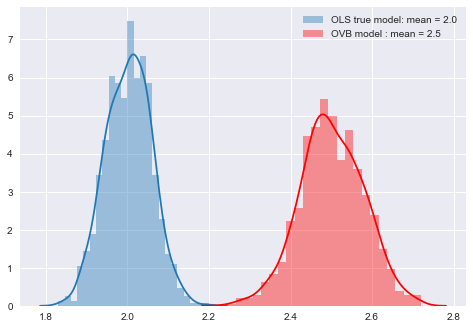

In [71]:
sns.distplot(beta_ols, color="#1f77b4",
             label = 'OLS true model: mean = {}'.format(round(np.mean(beta_ols), 2)))
sns.distplot(beta_ovb, color="r",
             label = 'OVB model : mean = {}'.format(round(np.mean(beta_ovb), 2)))
plt.legend();

## 7. Bad Control: Post Treatment Bias


